In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
def get_shape(tensor):
    "return the shape of tensor as list"
    return tensor.get_shape().as_list()

def print_var(string):
    "print var_name and var_shape in collection named string"
    print("\n".join(["{} : {}".format(v.name, get_shape(v)) for v in tf.get_collection(string)]))
    
def clip(x, vmax = 1-1e-7, vmin = 1e-7):
    "clip the x between vmax, vmin"
    return tf.clip_by_value(x, clip_value_max=vmax, clip_value_min=vmin)

In [3]:
mnist = input_data.read_data_sets('../MNIST_data', one_hot=True)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
train = {}
test = {}
val = {}
train['input'] = mnist.train.images
train['output'] = mnist.train.labels
test['input'] = mnist.test.images
test['output'] = mnist.test.labels
val['input'] = mnist.validation.images
val['output'] = mnist.validation.labels

In [5]:
# Model parameter
image_size = 28*28
hidden = 300
nclasses = 10

# Train parameter
learning_rate = 1e-4
epoch = 5
ntrain = len(train['input'])
batch_size = 100
nbatch = ntrain//batch_size
log_every = 50

In [6]:
x = tf.placeholder(dtype = tf.float32, shape = [None, image_size], name = 'image')
y = tf.placeholder(dtype = tf.float32, shape = [None, nclasses], name = 'label')

layer1 = {}
layer2 = {}

with tf.variable_scope("layer1"):
    layer1['w'] = tf.Variable(initial_value = tf.random_normal(shape = [image_size, hidden], mean = 0.0, stddev = 1.0),
                              name = 'weight')
    layer1['b'] = tf.Variable(initial_value = tf.constant(value=0.0, shape = [hidden]),
                              name = 'bias')
    layer1['output'] = tf.nn.sigmoid(tf.add(tf.matmul(x, layer1['w']), layer1['b']))

with tf.variable_scope("layer2"):
    layer2['w'] = tf.Variable(initial_value = tf.random_normal(shape = [hidden, nclasses], mean = 0.0, stddev = 1.0),
                              name = 'weight')
    layer2['b'] = tf.Variable(initial_value = tf.constant(value=0.0, shape = [nclasses]),
                              name = 'bias')
    layer2['output'] = tf.nn.softmax(tf.add(tf.matmul(layer1['output'], layer2['w']), layer2['b']))

In [8]:
print_var("trainable_variables")

layer1/weight:0 : [784, 300]
layer1/bias:0 : [300]
layer2/weight:0 : [300, 10]
layer2/bias:0 : [10]


### Cross entropy
$y[i][j] = $ True Label(one hot)  
$output[i][j] = $ Output of Neural Network

$$cross entropy = \sum_{i} \sum_{j=1}^{10} y[i][j]\log(output[i][j])$$

In [9]:
cross_entropy = -tf.reduce_mean(y*tf.log(clip(layer2['output'])))

### tf.argmax(2Darray, axis = 1)
[http://nbviewer.jupyter.org/github/maestrojeong/tensorflow_api/blob/master/tensorflow_1.0.0/tensorflow_api.ipynb](http://nbviewer.jupyter.org/github/maestrojeong/tensorflow_api/blob/master/tensorflow_1.0.0/tensorflow_api.ipynb)

In [10]:
correct_prediction = tf.equal(tf.argmax(layer2['output'], 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [11]:
run_train = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

In [14]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Epoch(1/5) 50 th batch train : 15.0 %, validation : 13.5 %
Epoch(1/5) 100 th batch train : 17.0 %, validation : 15.5 %
Epoch(1/5) 150 th batch train : 19.0 %, validation : 17.5 %
Epoch(1/5) 200 th batch train : 19.0 %, validation : 19.4 %
Epoch(1/5) 250 th batch train : 18.0 %, validation : 21.7 %
Epoch(1/5) 300 th batch train : 25.0 %, validation : 24.2 %
Epoch(1/5) 350 th batch train : 27.0 %, validation : 26.6 %
Epoch(1/5) 400 th batch train : 31.0 %, validation : 28.4 %
Epoch(1/5) 450 th batch train : 16.0 %, validation : 30.5 %
Epoch(1/5) 500 th batch train : 25.0 %, validation : 32.7 %
Epoch(1/5) 550 th batch train : 38.0 %, validation : 35.4 %
Epoch(2/5) 50 th batch train : 37.0 %, validation : 38.4 %
Epoch(2/5) 100 th batch train : 34.0 %, validation : 41.3 %
Epoch(2/5) 150 th batch train : 38.0 %, validation : 44.0 %
Epoch(2/5) 200 th batch train : 49.0 %, validation : 46.1 %
Epoch(2/5) 250 th batch train : 46.0 %, validation : 48.6 %
Epoch(2/5) 300 th batch train : 46.0 %, va

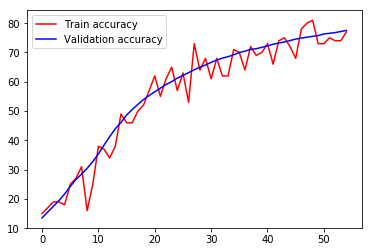

In [15]:
train_accuracy_tract = []
val_accuracy_tract = []

for epoch_ in range(epoch):
    index = np.arange(len(train['input']))
    np.random.shuffle(index)
    trX = train['input'][index]
    trY = train['output'][index]
    val_feed_dict = {x : val['input'], 
                     y : val['output']}
    
    for nbatch_ in range(nbatch):
        train_feed_dict = {x : trX[batch_size*nbatch_:batch_size*(nbatch_+1)], 
                           y : trY[batch_size*nbatch_:batch_size*(nbatch_+1)]}
        sess.run(run_train, feed_dict=train_feed_dict)
        
        if nbatch_%log_every == log_every - 1:
            train_accuracy = 100*sess.run(accuracy, feed_dict=train_feed_dict)
            val_accuracy = 100*sess.run(accuracy, feed_dict= val_feed_dict)
            train_accuracy_tract.append(train_accuracy)
            val_accuracy_tract.append(val_accuracy)
            print("Epoch(%d/%d) %d th batch train : %.1f %%, validation : %.1f %%"%(epoch_+1, epoch, nbatch_+1, train_accuracy, val_accuracy))

test_feed_dict = {x : test['input'],  
                  y : test['output']}

test_accuracy = 100*sess.run(accuracy, feed_dict=test_feed_dict)
print("Test accuracy=%.1f %%"%(test_accuracy))
plt.plot(train_accuracy_tract, 'r-', label = 'Train accuracy')
plt.plot(val_accuracy_tract, 'b-', label = 'Validation accuracy')
plt.legend()
plt.show()